# XGBoost Model - Energy Cost Prediction with Time Series

## Import Libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Import Data as Dataframe

- Import our cleaned data
- Set datetime column as index
- Convert our index to datetime object

In [68]:
df = pd.read_csv('./data/prepared/df_energy_climate_2020.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

## Visualize our data - Energy Price Transition in 2020

<AxesSubplot: title={'center': 'Energy price in 2020'}, xlabel='datetime'>

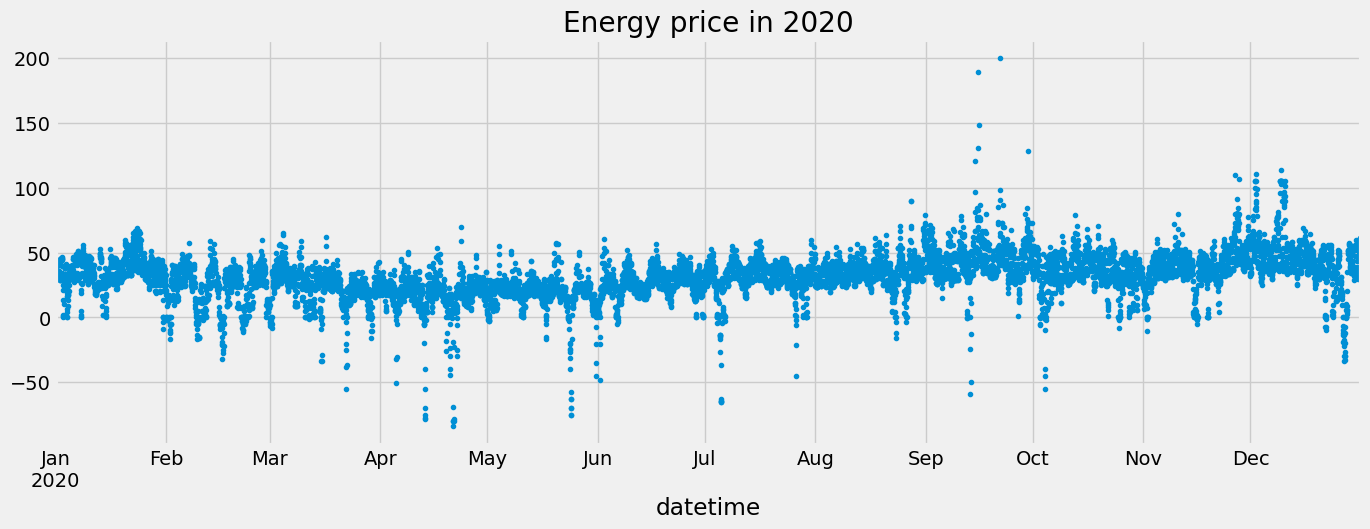

In [69]:
df['energy_price'].plot(
    style='.', 
    figsize=(15, 5),
    color=color_pal[0], # type: ignore
    title='Energy price in 2020'
)

## Train / Test Split

- Split the data into Train : Test = 8 : 2

In [70]:
splitting_point = (int(len(df)*0.2))
train, test = df[:-splitting_point], df[-splitting_point:]

## Visualize Train / Test Data

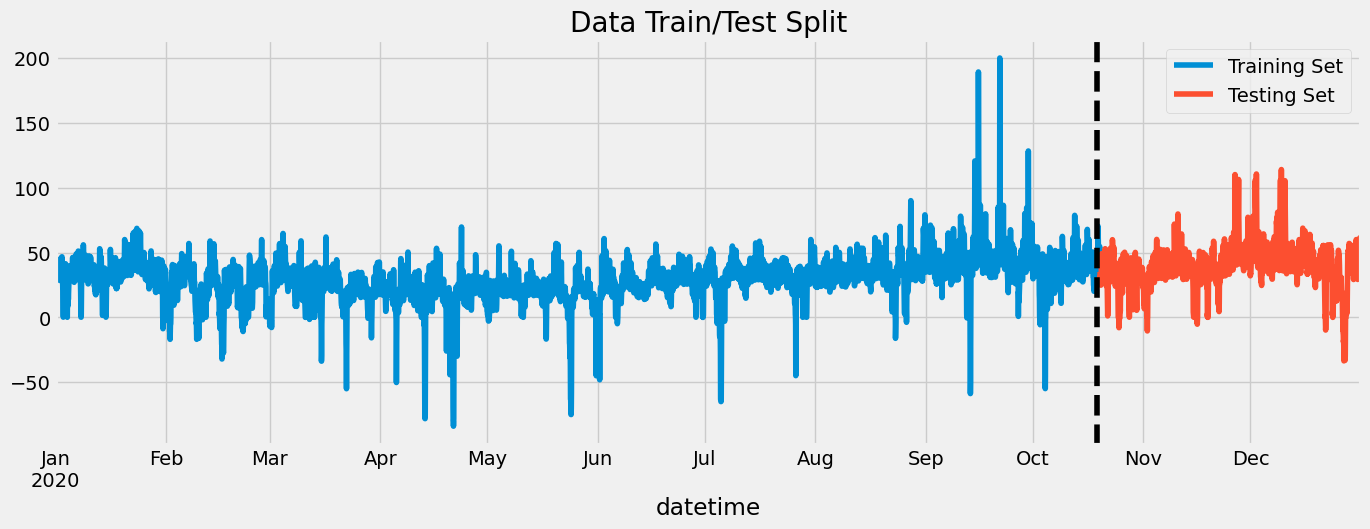

In [71]:
fig, ax = plt.subplots(figsize =(15, 5))
train.plot(ax=ax, y='energy_price', label = 'Training Set', title='Data Train/Test Split')
test.plot(ax=ax, y='energy_price', label = 'Testing Set')
ax.axvline('2020-10-19', color='black', ls='--') # type: ignore
plt.show()

In [72]:
df.index[-splitting_point]

Timestamp('2020-10-19 20:00:00')

## Visualize Data of one week

<AxesSubplot: title={'center': 'Week of data'}, xlabel='datetime'>

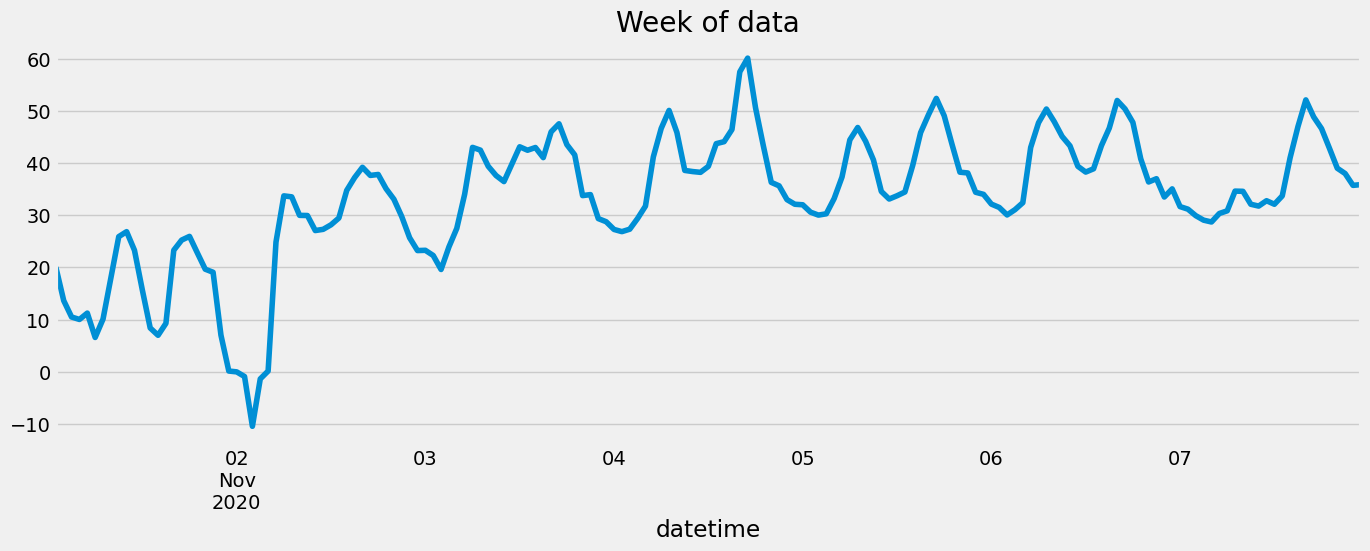

In [73]:
df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['energy_price'].plot(figsize=(15,5), title='Week of data')

## Set our Feature and Target
- Target = Energy price
- Features = Hour, Day of Week, Month

In [74]:
FEATURES = ['hour', 'dayofweek', 'month']
TARGET = 'energy_price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Create our Model

In [75]:
# Set random state to ensure reproductivity
reg = xgb.XGBRegressor(random_state=0)

## Train our Model and make Predictions

In [76]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
)

[0]	validation_0-rmse:24.12732	validation_1-rmse:33.18543
[99]	validation_0-rmse:9.25153	validation_1-rmse:16.65789


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

## Visualize Truth and Predictions

/var/folders/cz/cwy65nds1w7_vfh7mtxwrks40000gn/T/ipykernel_3139/2541921120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


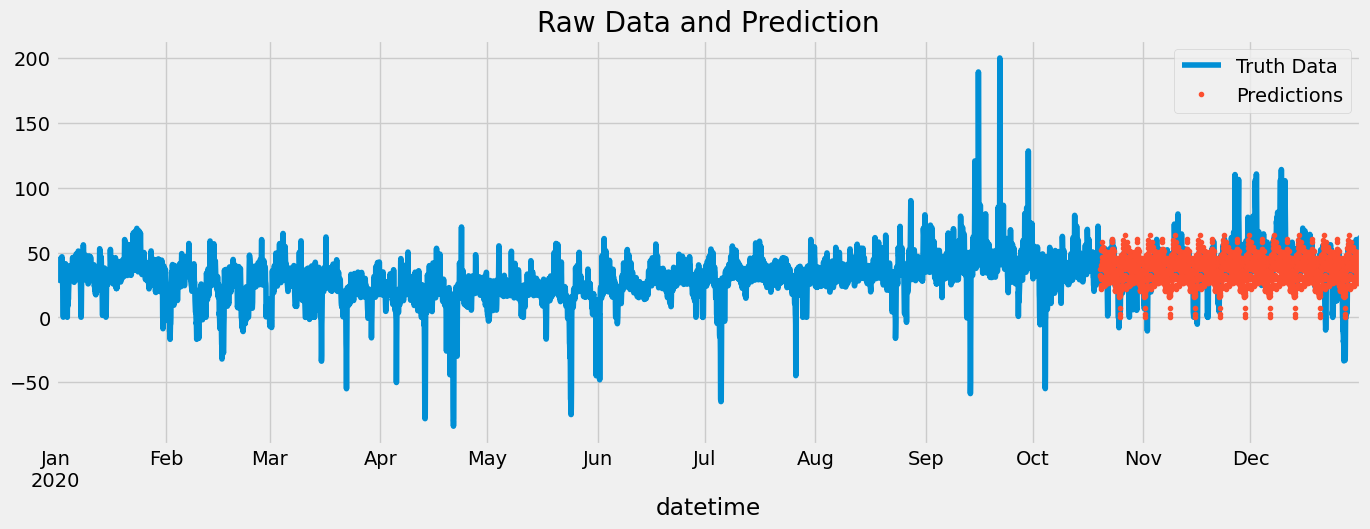

In [77]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['energy_price']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

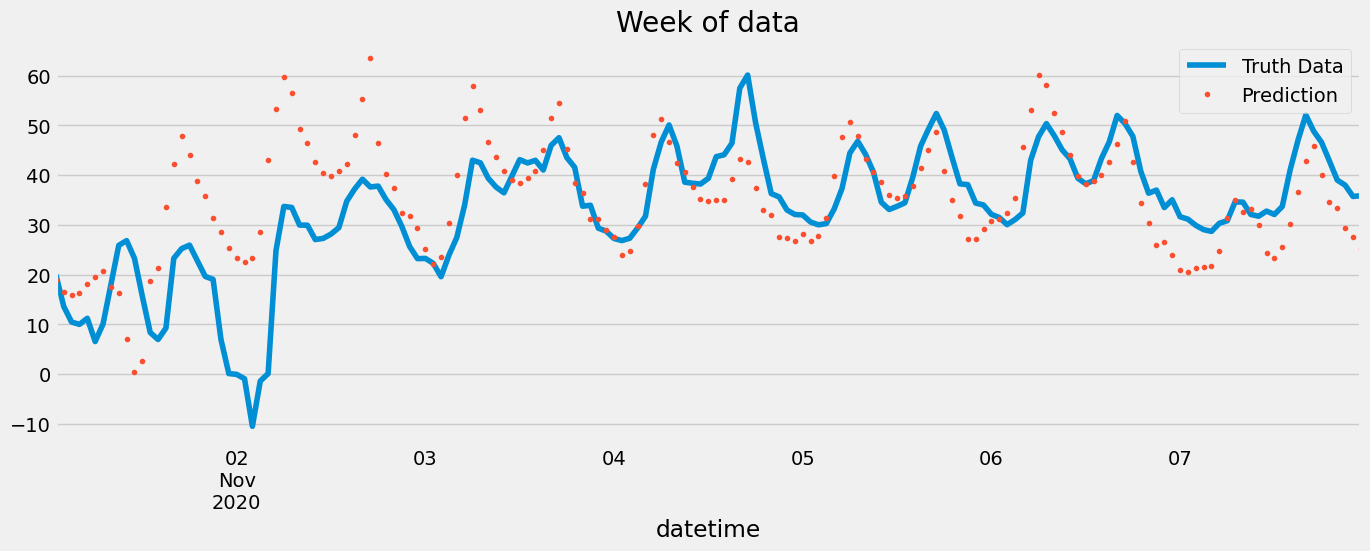

In [78]:
ax = df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['energy_price'].plot(figsize=(15,5), title='Week of data')
df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

## Evaluate our Model
- We use two evaluation metrics
    - RMSE 
    - MAPE

- RMSE (Root Mean Squared Error)
    - Measures the average distance between the predicted values and the actual values (squared difference is taking into account)
    - RMSE gives more weight to **larger errors** and is useful when it is important to minimize the impact of large errors
    - It can be heavily influenced by outliers
    - Useful when comparing the performance of different models
    - It is not always easy to interpret the magnitude of the error as it is not a percentage
- MAPE (Mean Absolute Percentae Error)
    - Measures the average percentage difference between the predicted values and actual values
    - Useful when the data contains different scales or magnitudes, as it normalizes the error by the actual value
    - It is more interpretable
    - It may be undefined or produce very large values when the actual values are close to zero
    - It is not symmetric => The errors in the predicted values may not be weighted equally in both directions

In [79]:
score_rmse = np.sqrt(mean_squared_error(test['energy_price'], test['prediction']))
print(f'RMSE Score on test set: {score_rmse:.2f}')
score_mape = (mean_absolute_percentage_error(test['energy_price'], test['prediction']))
print(f'MAPE Score on test set: {score_mape:.2f}')

RMSE Score on test set: 16.66
MAPE Score on test set: 11.70


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |           

## Search for hyperparameters

### What are hyperparameters?
- They re not lerned by the model during the training but set beforehand by the user or the researcher
- They can have a significant impact on the performance of the model 

In [80]:
reg_hyper_p = xgb.XGBRegressor(random_state=0)

- We use grid search
- We search for the best parameters for 
    - n_estimators: the number of trees built before taking the maximum voting or averages of predictions
    - max_depth: the longest path between the root node and the leaf node 
    - gamma: controls minimum loss reduction required to split a node during tree construction
    - learning_rate: used to govern the pace at which an algorithm updates or learns the values of a parameter estimate

In [81]:
# make a dictionary of hyperparameter values to search
search_space = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'gamma': [0.01, 0.1],
    'learning_rate': [0.001, 0.01, 0.1],
}

GS = GridSearchCV(estimator = reg_hyper_p,
                  param_grid = search_space,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit = 'r2', # type: ignore
                  cv = 5,
                #   verbose=4
)

In [82]:
GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0, ...),
             param_grid={'gamma': [0.01, 0.1],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 500, 1000]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [83]:
print(GS.best_params_)

{'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


## Create a Model with Hyperparameters

In [84]:
reg_hyper_p = xgb.XGBRegressor(
    gamma=0.1,
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    random_state=0
)

In [85]:
reg_hyper_p.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
)

[0]	validation_0-rmse:32.00740	validation_1-rmse:42.73430
[100]	validation_0-rmse:16.79386	validation_1-rmse:22.23874
[200]	validation_0-rmse:12.84260	validation_1-rmse:17.54612
[300]	validation_0-rmse:11.78742	validation_1-rmse:16.36642
[400]	validation_0-rmse:11.32280	validation_1-rmse:15.99089
[499]	validation_0-rmse:11.03981	validation_1-rmse:15.88613


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

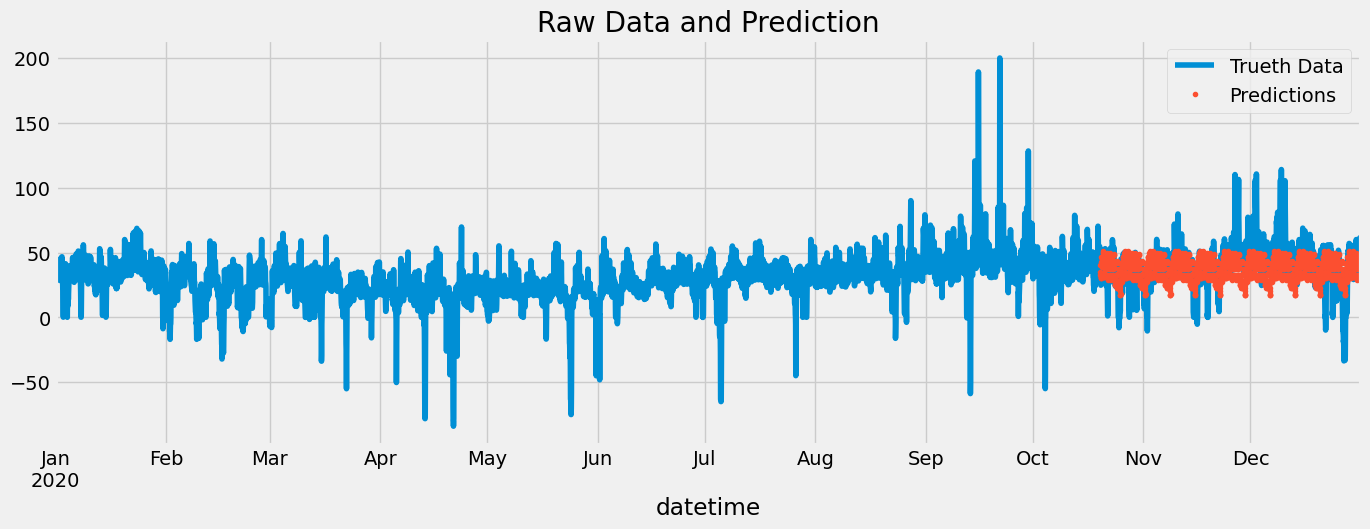

In [86]:
test['prediction_hyp'] = reg_hyper_p.predict(X_test)
df = df.merge(test[['prediction_hyp']], how='left', left_index=True, right_index=True)
ax = df[['energy_price']].plot(figsize=(15, 5))
df['prediction_hyp'].plot(ax=ax, style='.')
plt.legend(['Trueth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

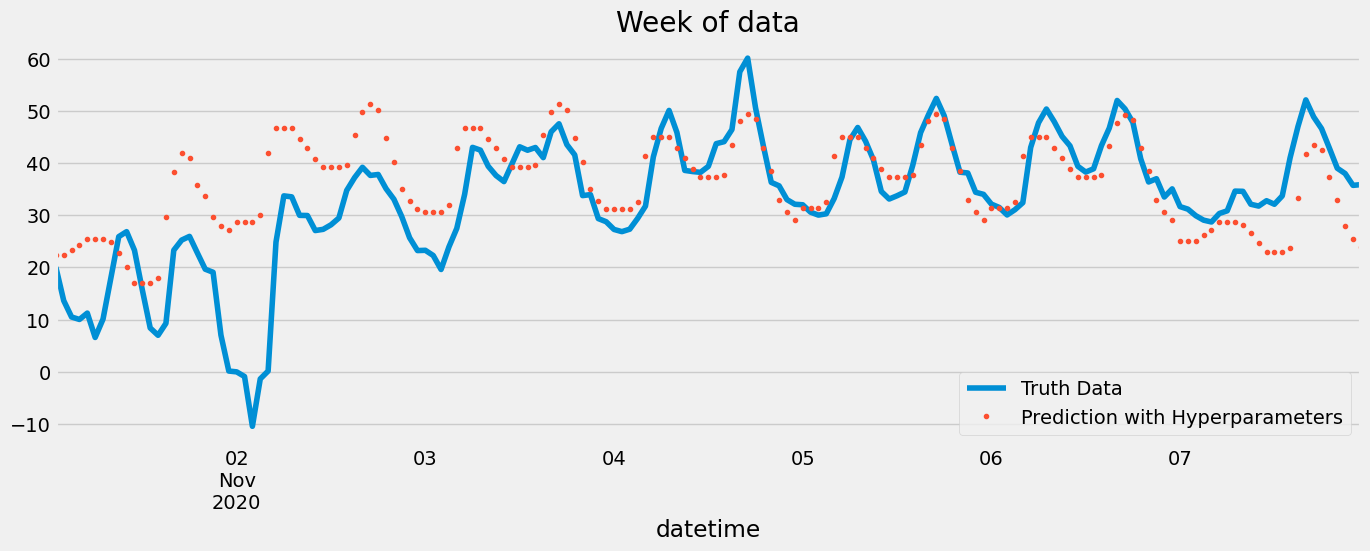

In [87]:
ax = df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['energy_price'].plot(figsize=(15,5), title='Week of data')
df.loc[(df.index > '2020-11-01') & (df.index < '2020-11-08')]['prediction_hyp'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction with Hyperparameters'])
plt.show()

In [88]:
score_rmse = np.sqrt(mean_squared_error(test['energy_price'], test['prediction_hyp']))
print(f'RMSE Score on test set: {score_rmse:.2f}')
score_mape = (mean_absolute_percentage_error(test['energy_price'], test['prediction_hyp']))
print(f'MAPE Score on test set: {score_mape:.2f}')

RMSE Score on test set: 15.89
MAPE Score on test set: 12.59


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |          


### RMSE improved slightly, but MAPE worsened. What does it mean?
This may occur when the model is accurately predicting the values close to the actual values, but making larger errors for the values that are farther from the actual values.

## Removing outliers

<AxesSubplot: ylabel='Frequency'>

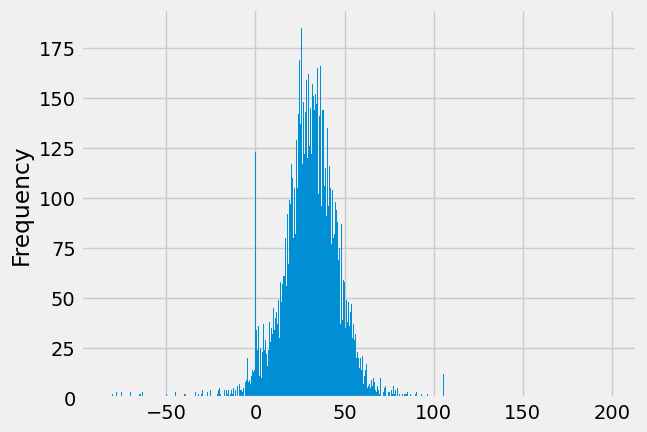

In [89]:
df['energy_price'].plot(kind='hist', bins=500)

<AxesSubplot: xlabel='datetime'>

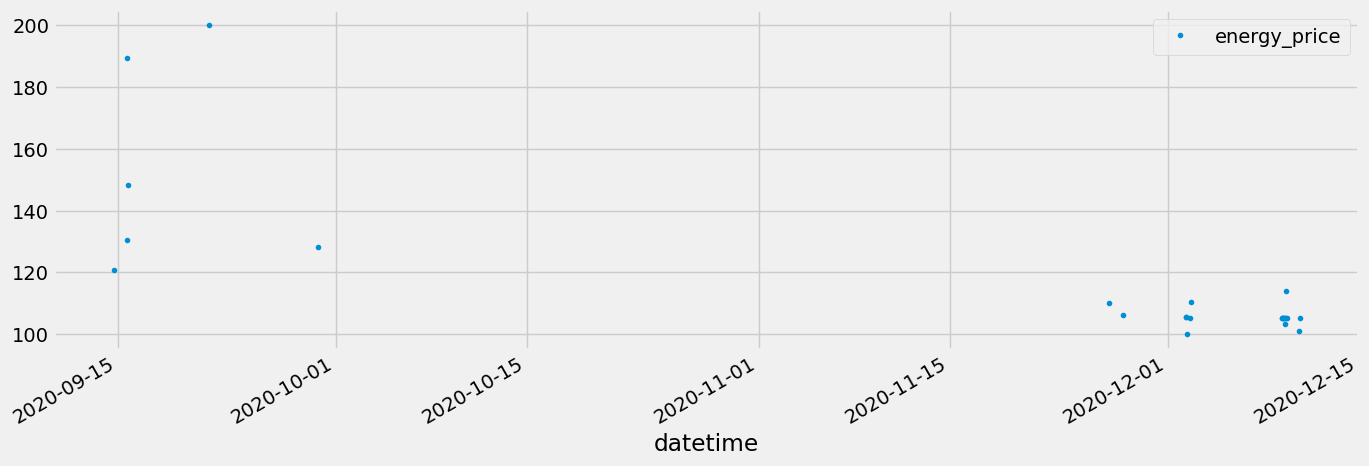

In [90]:
df.query('energy_price > 100').plot(y='energy_price', figsize=(15, 5), style='.')

<AxesSubplot: xlabel='datetime'>

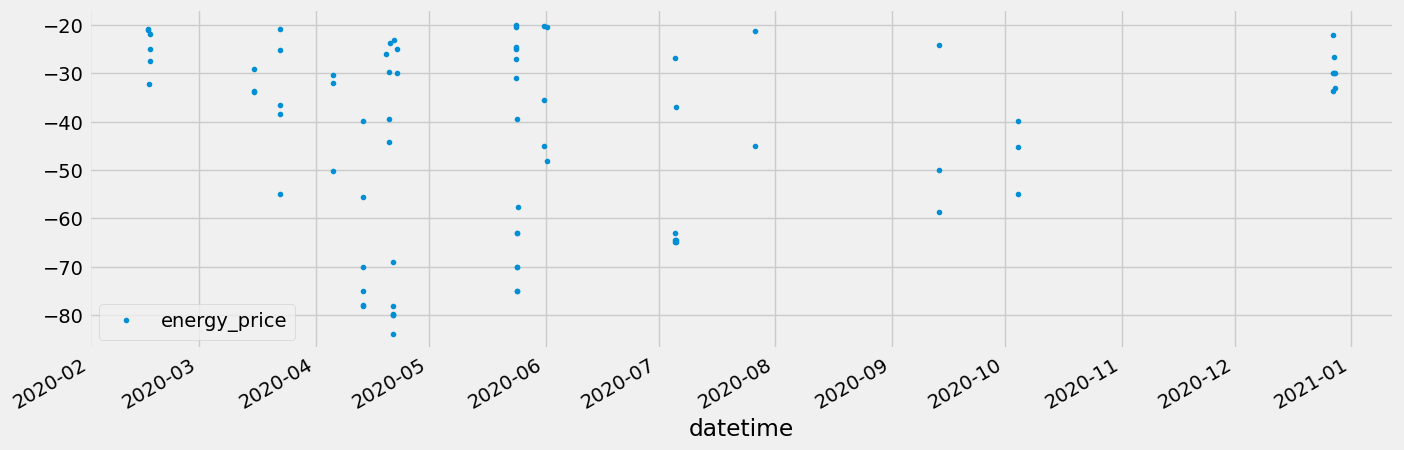

In [91]:
df.query('energy_price < -20').plot(y='energy_price', figsize=(15, 5), style='.')

In [92]:
df = df.query('energy_price < 100').copy()
df = df.query('energy_price > -20').copy()

In [93]:
splitting_point = (int(len(df)*0.2))
train, test = df[:-splitting_point], df[-splitting_point:]
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg_hyper_p.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:31.43654	validation_1-rmse:41.62303
[100]	validation_0-rmse:15.21432	validation_1-rmse:20.98159
[200]	validation_0-rmse:10.82200	validation_1-rmse:15.75657
[300]	validation_0-rmse:9.67117	validation_1-rmse:14.49550
[400]	validation_0-rmse:9.22279	validation_1-rmse:14.11199
[499]	validation_0-rmse:8.96248	validation_1-rmse:14.01445


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

/var/folders/cz/cwy65nds1w7_vfh7mtxwrks40000gn/T/ipykernel_3139/2643222670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_less_outliers'] = reg_hyper_p.predict(X_test)


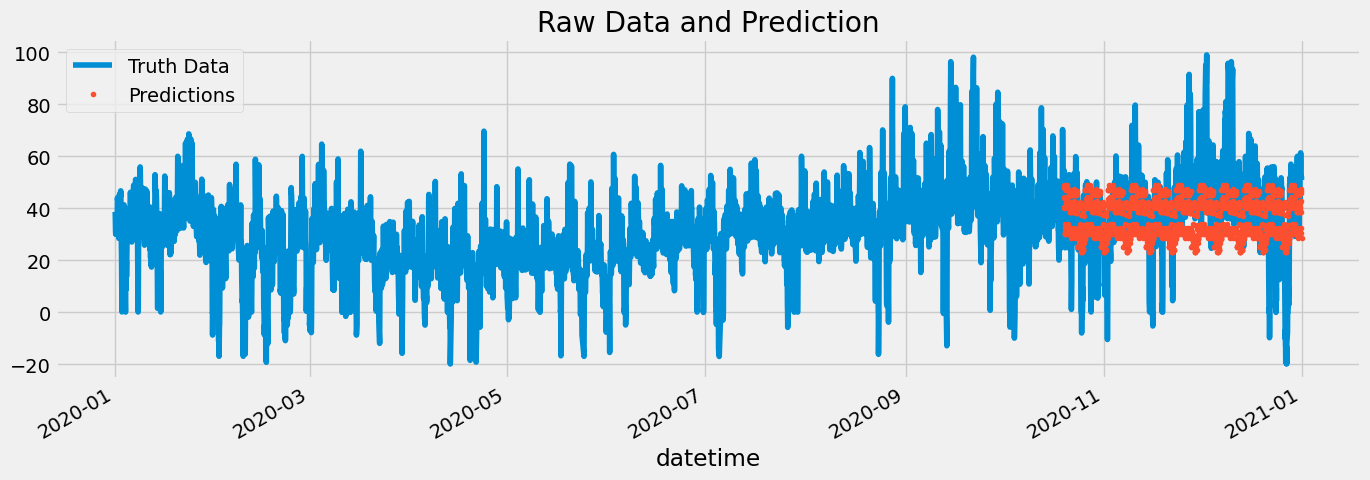

In [94]:
test['prediction_less_outliers'] = reg_hyper_p.predict(X_test)
df = df.merge(test[['prediction_less_outliers']], how='left', left_index=True, right_index=True)
ax = df[['energy_price']].plot(figsize=(15, 5))
df['prediction_less_outliers'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [95]:
score_rmse = np.sqrt(mean_squared_error(test['energy_price'], test['prediction_less_outliers']))
print(f'RMSE Score on test set: {score_rmse:.2f}')
score_mape = (mean_absolute_percentage_error(test['energy_price'], test['prediction_less_outliers']))
print(f'MAPE Score on test set: {score_mape:.2f}')

RMSE Score on test set: 14.01
MAPE Score on test set: 12.76


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.01  |12.76%  | 

## Time Series Cross Validation

### What is Cross Validation?
Cross-validation is an essential technique used in machine learning to evaluate the performance of a model on unseen data.

### Benefits of Cross Validation
- It provides a more accurate estimate of a model's performance on new data
- Helps to identify overfitting
- Allows for tuning of hyperparameters to optimize model performance

[0]	validation_0-rmse:31.89252	validation_1-rmse:54.50318
[100]	validation_0-rmse:15.41030	validation_1-rmse:32.65834
[200]	validation_0-rmse:10.90225	validation_1-rmse:25.43451
[300]	validation_0-rmse:9.76342	validation_1-rmse:23.03054
[400]	validation_0-rmse:9.31275	validation_1-rmse:22.13586
[499]	validation_0-rmse:9.07683	validation_1-rmse:21.88130
[0]	validation_0-rmse:32.04861	validation_1-rmse:51.83055
[100]	validation_0-rmse:15.44616	validation_1-rmse:30.44591
[200]	validation_0-rmse:10.91026	validation_1-rmse:23.59759
[300]	validation_0-rmse:9.76634	validation_1-rmse:21.35380
[400]	validation_0-rmse:9.32299	validation_1-rmse:20.50579
[499]	validation_0-rmse:9.09071	validation_1-rmse:20.22499
[0]	validation_0-rmse:32.67427	validation_1-rmse:46.82973
[100]	validation_0-rmse:15.78352	validation_1-rmse:23.82427
[200]	validation_0-rmse:11.19144	validation_1-rmse:10.84635
[300]	validation_0-rmse:10.02672	validation_1-rmse:7.34545
[400]	validation_0-rmse:9.60486	validation_1-rmse:7.2

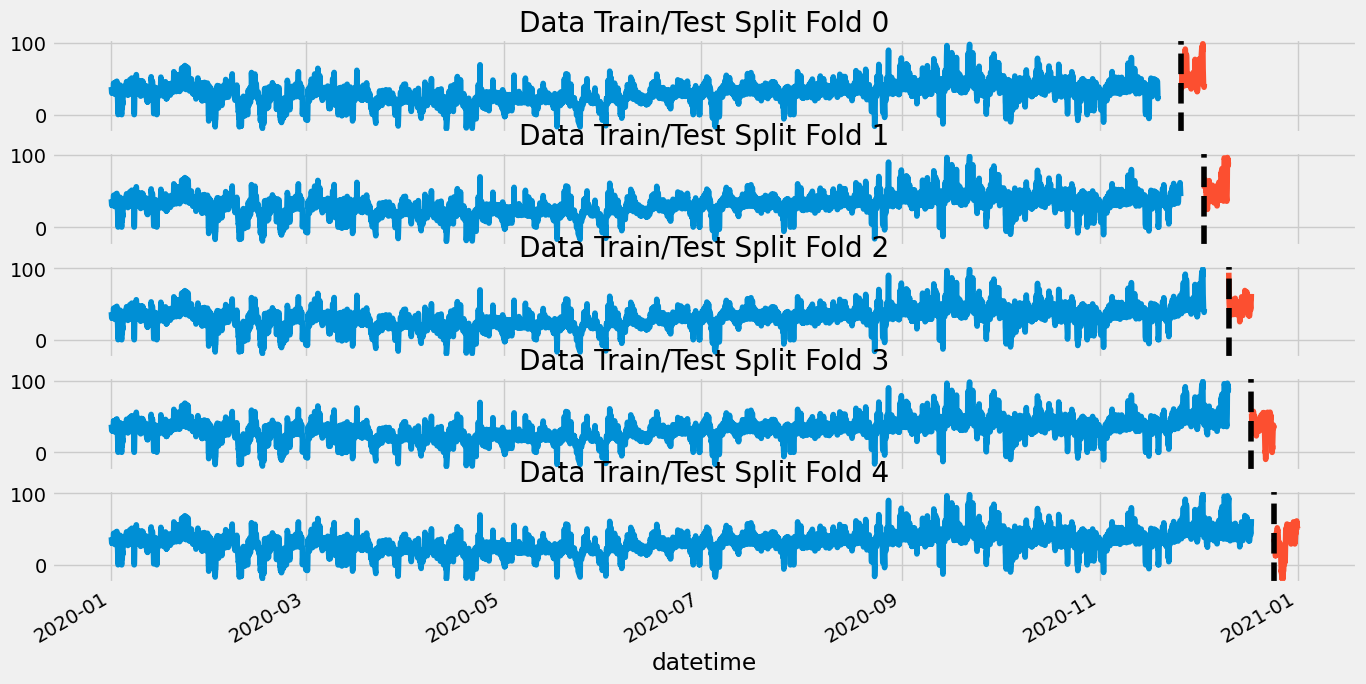

In [96]:
tss = TimeSeriesSplit(n_splits=5, test_size=168, gap=168)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 8), sharex=True)

fold = 0
preds = []
scores_rmse = []
scores_mape = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['energy_price'].plot(ax=axs[fold],
                               label='Training Set',
                               title=f'Data Train/Test Split Fold {fold}')
    test['energy_price'].plot(ax=axs[fold],
                              label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    FEATURES = ['month', 'hour', 'dayofweek']
    TARGET = 'energy_price'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        gamma=0.1,
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        random_state=0
    )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_rmse.append(score_rmse)
    score_mape = (mean_absolute_percentage_error(y_test, y_pred))
    scores_mape.append(score_mape)
    
    fold += 1

In [97]:
print(f'RMSE scores across folds {np.mean(scores_rmse):.2f}')
print(f'Fold RMSE scores: {scores_rmse}')
print(f'MAPE scores across folds {np.mean(scores_mape):.2f}')
print(f'Fold MAPE scores: {scores_mape}')

RMSE scores across folds 17.94
Fold RMSE scores: [21.881300478639638, 20.224992398217644, 8.390796963503277, 17.736895595834223, 21.473530547095745]
MAPE scores across folds 12.58
Fold MAPE scores: [0.3479631804203069, 0.28994661041356495, 0.1491597328844766, 27.245268201246468, 34.86918116338301]


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.01  |12.76%  |
| Model 3 | Results in Cross Validation |17.94  | 12.58% | 

## Time Series Cross Validation with Lag Features

In [98]:
def add_past_covariants(df, column):
    df[f'{column}_lag1'] = df[column].shift(168)
    df[f'{column}_lag2'] = df[column].shift(24)
    df[f'{column}_lag3'] = df[column].shift(12)
    df[f'{column}_lag4'] = df[column].shift(1)
    
    return df

In [99]:
df = add_past_covariants(df, 'energy_price')
df = add_past_covariants(df, 'wind_speed')
df = add_past_covariants(df, 'solar_radiation')
df = add_past_covariants(df, 'renewable')
df = add_past_covariants(df, 'not_renewable')
df = add_past_covariants(df, 'nuclear_power')

## Take All Past Covariates

In [100]:
tss = TimeSeriesSplit(n_splits=5, test_size=168, gap=168)
df = df.sort_index()

fold = 0
preds = []
scores_rmse = []
scores_mape = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['month', 'hour', 'dayofweek', 'energy_price_lag1', 'energy_price_lag2', 'energy_price_lag3', 'energy_price_lag4', 'wind_speed_lag1', 'wind_speed_lag2', 'wind_speed_lag3', 'wind_speed_lag4', 'solar_radiation_lag1', 'solar_radiation_lag2', 'solar_radiation_lag3','solar_radiation_lag4', 'renewable_lag1', 'renewable_lag2', 'renewable_lag3','renewable_lag4', 'not_renewable_lag1', 'not_renewable_lag2', 'not_renewable_lag3','not_renewable_lag4', 'nuclear_power_lag1', 'nuclear_power_lag2', 'nuclear_power_lag3', 'nuclear_power_lag4']
    TARGET = 'energy_price'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        gamma=0.1,
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        random_state=0
    )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_rmse.append(score_rmse)
    score_mape = (mean_absolute_percentage_error(y_test, y_pred))
    scores_mape.append(score_mape)
    fold += 1

[0]	validation_0-rmse:31.86293	validation_1-rmse:54.36005
[100]	validation_0-rmse:12.53068	validation_1-rmse:23.69229
[200]	validation_0-rmse:6.17122	validation_1-rmse:12.81788
[300]	validation_0-rmse:4.39425	validation_1-rmse:9.03969
[400]	validation_0-rmse:3.78322	validation_1-rmse:7.51959
[499]	validation_0-rmse:3.44908	validation_1-rmse:6.84264
[0]	validation_0-rmse:32.01932	validation_1-rmse:51.71638
[100]	validation_0-rmse:12.58727	validation_1-rmse:23.01394
[200]	validation_0-rmse:6.19468	validation_1-rmse:13.10900
[300]	validation_0-rmse:4.41066	validation_1-rmse:9.77165
[400]	validation_0-rmse:3.81516	validation_1-rmse:8.61417
[499]	validation_0-rmse:3.48182	validation_1-rmse:8.11189
[0]	validation_0-rmse:32.64364	validation_1-rmse:46.73383
[100]	validation_0-rmse:12.82467	validation_1-rmse:18.28143
[200]	validation_0-rmse:6.28364	validation_1-rmse:7.88642
[300]	validation_0-rmse:4.45315	validation_1-rmse:4.65778
[400]	validation_0-rmse:3.83659	validation_1-rmse:3.82481
[499]	

In [101]:
print(f'RMSE scores across folds {np.mean(scores_rmse):.2f}')
print(f'Fold RMSE scores: {scores_rmse}')
print(f'MAPE scores across folds {np.mean(scores_mape):.2f}')
print(f'Fold MAPE scores: {scores_mape}')

RMSE scores across folds 5.52
Fold RMSE scores: [6.8426357620613265, 8.111894575761001, 3.5946728233826266, 4.38657621233618, 4.6654563927629775]
MAPE scores across folds 1.68
Fold MAPE scores: [0.07030651213270955, 0.09111202145940671, 0.056133094547633836, 5.102171284874555, 3.06426572067531]


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.01  |12.76%  |
| Model 3 | Results in Cross Validation |17.94  | 12.58% | 
| Model 4 | Model 3 with lag features(1), results in Cross validation | 5.52  | 1.68%  | 

(1) Below features lagged by one week, one day, 12 hours and one hour are included:
- Energy price
- Wind speed
- Solar radiation
- Renewable energy feeding volume
- Not renewable energy feeding volume
- Nuclear energy feeding volume

## Feature Importance

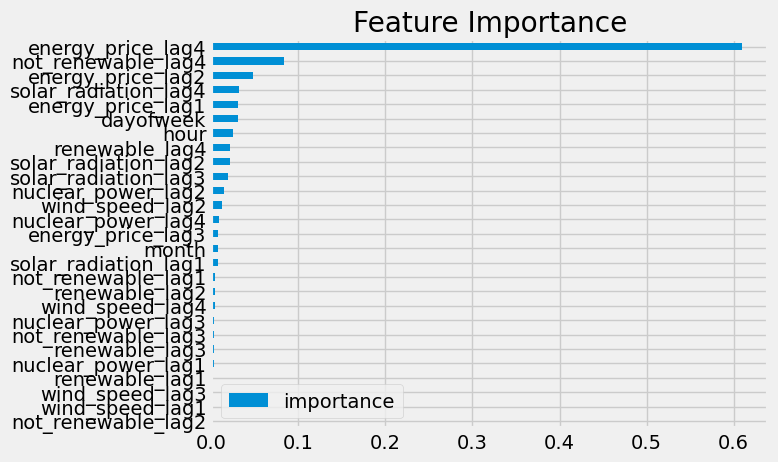

In [102]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Remove Past Covariates with less Importance

In [103]:
# gap: Number of samples to exclude from the end of each train set before the test set.
tss = TimeSeriesSplit(n_splits=5, test_size=168, gap=168)
df = df.sort_index()

fold = 0
preds = []
scores_rmse = []
scores_mape = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['hour', 'dayofweek', 'energy_price_lag1', 'energy_price_lag2', 
    'energy_price_lag4',  'wind_speed_lag2', 'solar_radiation_lag2', 'solar_radiation_lag3','solar_radiation_lag4', 'renewable_lag4',   'not_renewable_lag4', 'nuclear_power_lag2']
    TARGET = 'energy_price'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        gamma=0.1,
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        random_state=0
    )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_rmse.append(score_rmse)
    score_mape = (mean_absolute_percentage_error(y_test, y_pred))
    scores_mape.append(score_mape)
    fold += 1

[0]	validation_0-rmse:31.86293	validation_1-rmse:54.36005
[100]	validation_0-rmse:12.53068	validation_1-rmse:23.69229
[200]	validation_0-rmse:6.17174	validation_1-rmse:12.80279
[300]	validation_0-rmse:4.40464	validation_1-rmse:8.86474
[400]	validation_0-rmse:3.78983	validation_1-rmse:7.35352
[499]	validation_0-rmse:3.46653	validation_1-rmse:6.66264
[0]	validation_0-rmse:32.01932	validation_1-rmse:51.71638
[100]	validation_0-rmse:12.58727	validation_1-rmse:23.01394
[200]	validation_0-rmse:6.19427	validation_1-rmse:13.10130
[300]	validation_0-rmse:4.41691	validation_1-rmse:9.73135
[400]	validation_0-rmse:3.81830	validation_1-rmse:8.49896
[499]	validation_0-rmse:3.49262	validation_1-rmse:8.03322
[0]	validation_0-rmse:32.64364	validation_1-rmse:46.73383
[100]	validation_0-rmse:12.82467	validation_1-rmse:18.28143
[200]	validation_0-rmse:6.28364	validation_1-rmse:7.88642
[300]	validation_0-rmse:4.45396	validation_1-rmse:4.65605
[400]	validation_0-rmse:3.83705	validation_1-rmse:3.82686
[499]	

In [104]:
print(f'RMSE scores across folds {np.mean(scores_rmse):.2f}')
print(f'Fold RMSE scores: {scores_rmse}')
print(f'MAPE scores across folds {np.mean(scores_mape):.2f}')
print(f'Fold MAPE scores: {scores_mape}')

RMSE scores across folds 5.46
Fold RMSE scores: [6.662643110018479, 8.033222937339364, 3.6035465100561748, 4.378193316796051, 4.61409655032477]
MAPE scores across folds 1.64
Fold MAPE scores: [0.0660664748736523, 0.08945118453172148, 0.056520213844724776, 5.054704292060352, 2.9259811147562793]


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.01  |12.76%  |
| Model 3 | Results in Cross Validation |17.94  | 12.58% | 
| Model 4 | Model 3 with lag features(1), results in Cross validation | 5.52  | 1.68%  | 
| Model 5 | Model 3 with selected lag features(2) in Cross validation | 5.46  | 1.64%  | 

(1) Below features lagged by one week, one day, 12 hours and one hour are included:
- Energy price
- Wind speed
- Solar radiation
- Renewable energy feeding volume
- Not renewable energy feeding volume
- Nuclear energy feeding volume

(2) Below features are included:
- Energy price lagged by one week
- Energy price lagged by one day
- Energy price lagged by one hour
- Wind speed lagged by one day
- Solar radiation lagged by one day
- Solar radiation laggedy by 12 hours
- Solar radiation lagged by one hour
- Renewable energy feeding volume lagged by one day
- Not renewable energy feeding volume lagged by one hour
- Nuclear power by one day

## Finalize and Evaluate

In [105]:
# Import dataframe
df = pd.read_csv('./data/prepared/df_energy_climate_2020.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

# Remove outliers
df = df.query('energy_price < 100').copy()
df = df.query('energy_price > -20').copy()

one_week = 168

# Add past covariants
def add_past_covariants(df, column):
    df[f'{column}_cov'] = df[column]
    df.loc[(df.index >= df.index[-one_week], f'{column}_cov' )] = np.nan
    df[f'{column}_lag1'] = df[column].shift(168)
    df[f'{column}_lag2'] = df[column].shift(24)
    df[f'{column}_lag3'] = df[column].shift(12)
    df[f'{column}_lag4'] = df[column].shift(1)
    
    return df

df = add_past_covariants(df, 'energy_price')
df = add_past_covariants(df, 'wind_speed')
df = add_past_covariants(df, 'solar_radiation')
df = add_past_covariants(df, 'renewable')
df = add_past_covariants(df, 'not_renewable')
df = add_past_covariants(df, 'nuclear_power')

# Train / Test split
# We use the last week of the data as test data
train, test = df[:-one_week], df[-one_week:]

# Add features and set target
FEATURES = ['hour', 'dayofweek', 'energy_price_lag1', 'energy_price_lag2', 
     'energy_price_lag4',  'wind_speed_lag2', 'solar_radiation_lag2', 'solar_radiation_lag3','solar_radiation_lag4', 'renewable_lag4',   'not_renewable_lag4', 'nuclear_power_lag2']
TARGET = 'energy_price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Create a model
reg = xgb.XGBRegressor(
    gamma=0.1,
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    random_state=0
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# Make prediction
y_pred = reg.predict(X_test)

# Evaluate the model
score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score_mape = (mean_absolute_percentage_error(y_test, y_pred))

[0]	validation_0-rmse:33.56952	validation_1-rmse:38.95696
[100]	validation_0-rmse:13.15982	validation_1-rmse:15.44735
[200]	validation_0-rmse:6.40039	validation_1-rmse:7.63942
[300]	validation_0-rmse:4.53111	validation_1-rmse:5.52462
[400]	validation_0-rmse:3.91974	validation_1-rmse:4.83457
[499]	validation_0-rmse:3.58191	validation_1-rmse:4.54546


/var/folders/cz/cwy65nds1w7_vfh7mtxwrks40000gn/T/ipykernel_3139/2009793266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y_pred'] = y_pred


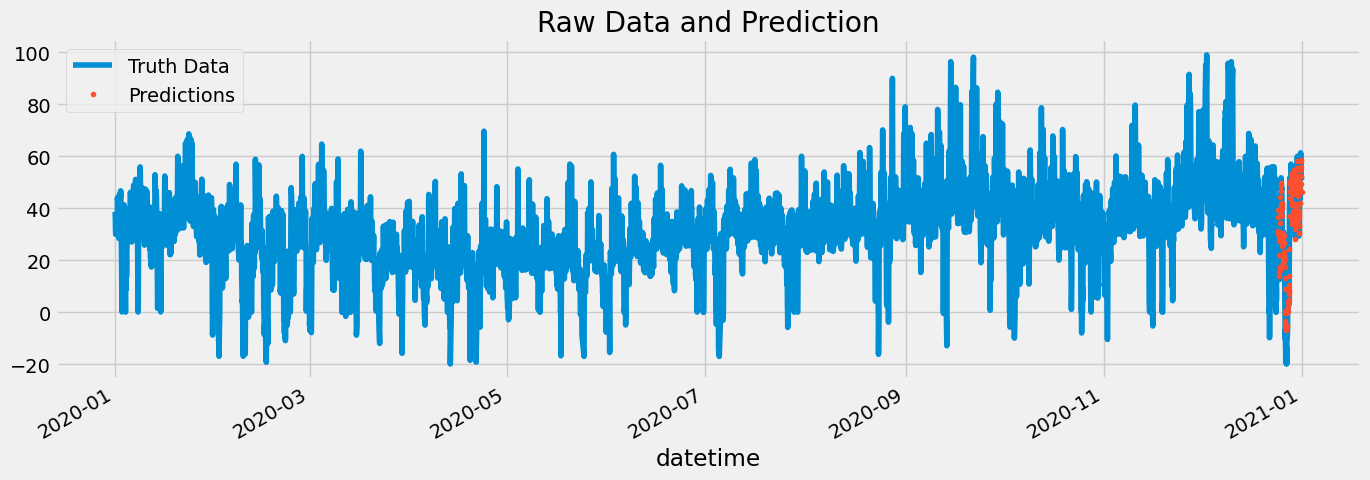

In [106]:
test['y_pred'] = y_pred
df = df.merge(test[['y_pred']], how='left', left_index=True, right_index=True)
ax = df[['energy_price']].plot(figsize=(15, 5))
df['y_pred'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [107]:
score_rmse = np.sqrt(mean_squared_error(test['energy_price'], test['y_pred']))
print(f'RMSE Score on test set: {score_rmse:.2f}')
score_mape = (mean_absolute_percentage_error(test['energy_price'], test['y_pred']))
print(f'MAPE Score on test set: {score_mape:.2f}')

RMSE Score on test set: 4.55
MAPE Score on test set: 2.87


| Model | Characteristics of the model       | RMSE | MAPE |
| --| -- | :----------------------: | :----------------------: | 
| Model 1 | XGBoost Regressor with Features Month, Day of week and Hour| 16.66 | 11.70% |    
| Model 2 | Model 1 with hyperparameters|15.89 | 12.59% |               
| Model 3 | Model 2 with data from which outliers are removed |14.01  |12.76%  |
| Model 3 | Results in Cross Validation |17.94  | 12.58% | 
| Model 4 | Model 3 with lag features(1), results in Cross validation | 5.52  | 1.68%  | 
| Model 5 | Model 3 with selected lag features(2) in Cross validation | 5.46  | 1.64%  | 
| Model 5 | Model 5, train : test = 51 weeks : 1 week | 4.55  | 2.87%  | 

(1) Below features lagged by one week, one day, 12 hours and one hour are included:
- Energy price
- Wind speed
- Solar radiation
- Renewable energy feeding volume
- Not renewable energy feeding volume
- Nuclear energy feeding volume

(2) Below features are included:
- Energy price lagged by one week
- Energy price lagged by one day
- Energy price lagged by one hour
- Wind speed lagged by one day
- Solar radiation lagged by one day
- Solar radiation laggedy by 12 hours
- Solar radiation lagged by one hour
- Renewable energy feeding volume lagged by one day
- Not renewable energy feeding volume lagged by one hour
- Nuclear power by one day

## Train Model with All Data and Predict Future

[0]	validation_0-rmse:33.56952	validation_1-rmse:38.95696
[100]	validation_0-rmse:13.15982	validation_1-rmse:15.44735
[200]	validation_0-rmse:6.40039	validation_1-rmse:7.63942
[300]	validation_0-rmse:4.53111	validation_1-rmse:5.52462
[400]	validation_0-rmse:3.91974	validation_1-rmse:4.83457
[499]	validation_0-rmse:3.58191	validation_1-rmse:4.54546


<AxesSubplot: title={'center': 'Future Prediction'}>

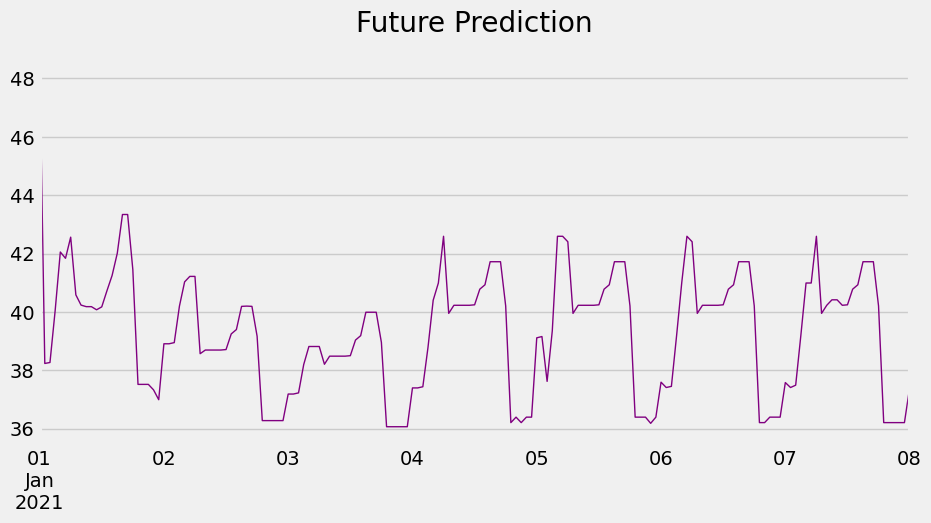

In [109]:
# Import dataframe
df = pd.read_csv('./data/prepared/df_energy_climate_2020.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

# Remove outliers
df = df.query('energy_price < 100').copy()
df = df.query('energy_price > -20').copy()

# Create a dataframe for future
future = pd.date_range('2021-01-01', '2021-01-08', freq='1h')
future_df = pd.DataFrame(index=future)
future_df.index = pd.to_datetime(future_df.index)
future_df['month'] = future_df.index.month
future_df['dayofweek'] = future_df.index.dayofweek
future_df['hour'] = future_df.index.hour

future_df['isFuture'] = True
df['isFuture'] = False

# Combine the data and future dataframe
df_and_future = pd.concat([df, future_df])

# Add past covariants
def add_past_covariants(df, column):
    df[f'{column}_lag1'] = df[column].shift(168)
    df[f'{column}_lag2'] = df[column].shift(24)
    df[f'{column}_lag3'] = df[column].shift(12)
    df[f'{column}_lag4'] = df[column].shift(1)
    
    return df

df_and_future = add_past_covariants(df_and_future, 'energy_price')
df_and_future = add_past_covariants(df_and_future, 'wind_speed')
df_and_future = add_past_covariants(df_and_future, 'solar_radiation')
df_and_future = add_past_covariants(df_and_future, 'renewable')
df_and_future = add_past_covariants(df_and_future, 'not_renewable')
df_and_future = add_past_covariants(df_and_future, 'nuclear_power')

# Define FEATURES
FEATURES = ['hour', 'dayofweek', 'energy_price_lag1', 'energy_price_lag2', 
'energy_price_lag4',  'wind_speed_lag2', 'solar_radiation_lag2', 'solar_radiation_lag3','solar_radiation_lag4', 'renewable_lag4',   'not_renewable_lag4', 'nuclear_power_lag2']

# Extract the part for future
future_w_features = df_and_future.query('isFuture').copy()


# Create a model
reg = xgb.XGBRegressor(
    gamma=0.1,
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    random_state=0
)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# Make prediction
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

future_w_features['pred'].plot(
    figsize=(10, 5),
    color='purple',
    ms=1,
    lw=1,
    title= 'Future Prediction'
)
